# Aula 7: X do SARIMAX, Auto ARIMA

- Revisão
    - AR, MA
    - I
    - S
    
- ARIMAX:
    - Como decidir se uma variável é útil
    - CCF
    


In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import warnings
from funcoes import all_ac, plot_forecast, teste_estacionariedade, diagnostico, compara_previsoes, correlacao_cruzada, compara_estatisticas
plt.rcParams["figure.figsize"] = [12, 5]
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
df = pd.read_csv('../../dados/clicks_original.csv')
df.index = pd.to_datetime(df['date'])
df = df.drop(['date'], axis=1)
df.index.freq = 'D'
df = df[:-1] # Tirando o último ponto por ser um outlier, vou discutir isso depois
df

/var/folders/f1/tdh3lyp114g78tg5wv2t7g3m0000gn/T/ipykernel_22636/1031137758.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df['date'])


,price,location,clicks
date,,,
2008-04-01,43.155647,2,18784
2008-04-02,43.079056,1,24738
2008-04-03,43.842609,2,15209
2008-04-04,43.312376,1,14018
2008-04-05,43.941176,1,11974
...,...,...,...
2008-08-08,43.730836,1,13744
2008-08-09,44.182033,1,6716
2008-08-10,43.608260,1,9523


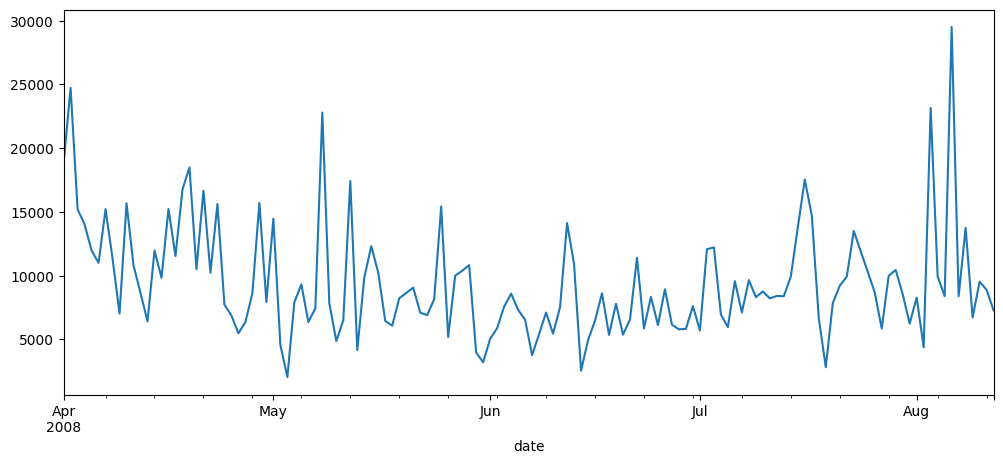

('Não Estacionário', 'Estacionário')

In [3]:
y = df['clicks']
y.plot()
plt.show()
teste_estacionariedade(y)

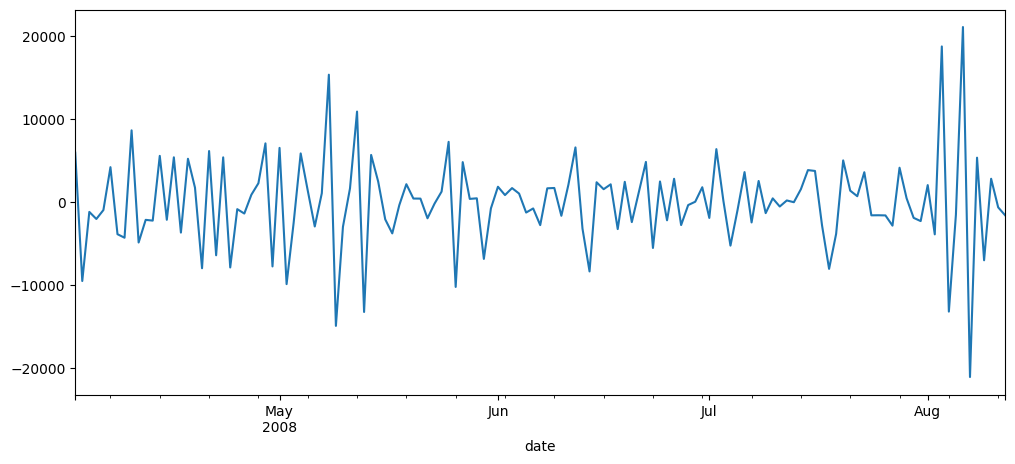

('Estacionário', 'Estacionário')

In [4]:
primeira_ordem = y.diff().dropna()
primeira_ordem.plot()
plt.show()
teste_estacionariedade(primeira_ordem)

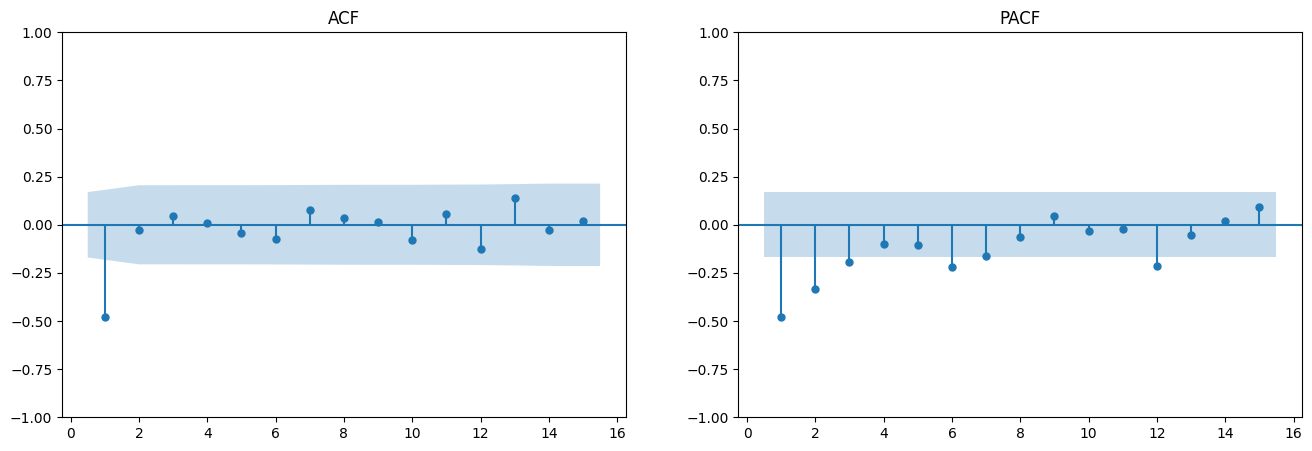

In [5]:
all_ac(primeira_ordem)

                               SARIMAX Results                                
Dep. Variable:                 clicks   No. Observations:                  134
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1301.175
Date:                Mon, 17 Mar 2025   AIC                           2606.350
Time:                        23:27:49   BIC                           2612.131
Sample:                    04-01-2008   HQIC                          2608.699
                         - 08-12-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9070      0.041    -22.370      0.000      -0.986      -0.828
sigma2      2.017e+07   9.42e-11   2.14e+17      0.000    2.02e+07    2.02e+07
Ljung-Box (L1) (Q):                   0.07   Jarque-

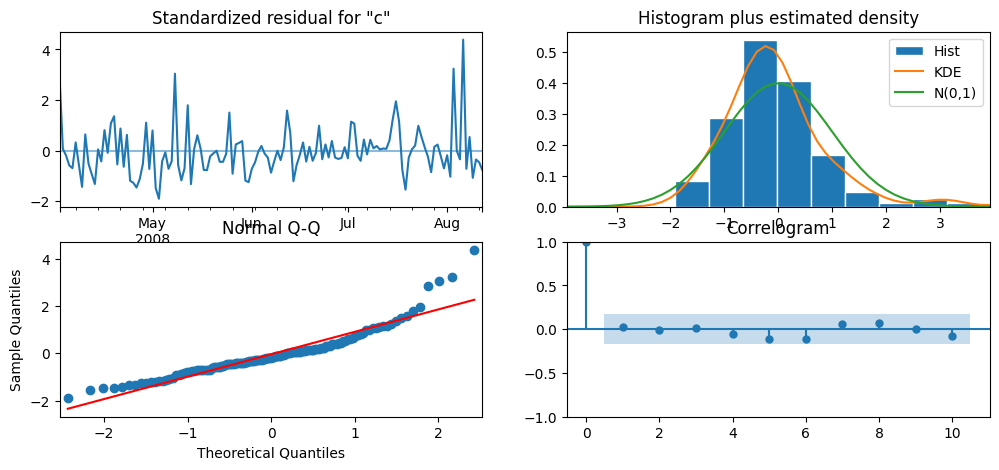

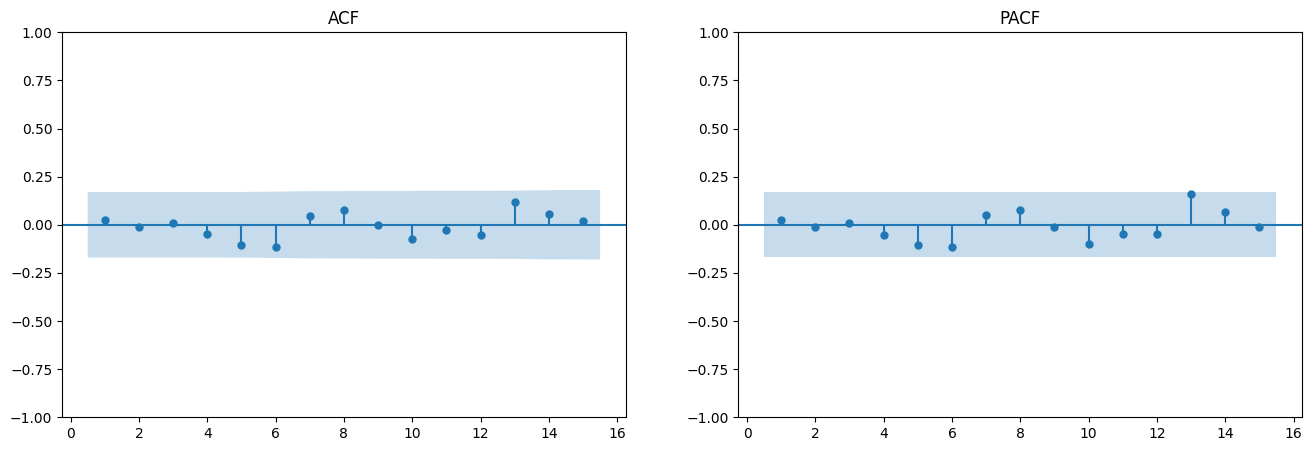

In [6]:
model1 = SARIMAX(y, order=(0,1,1)).fit(disp=False)
diagnostico(model1)

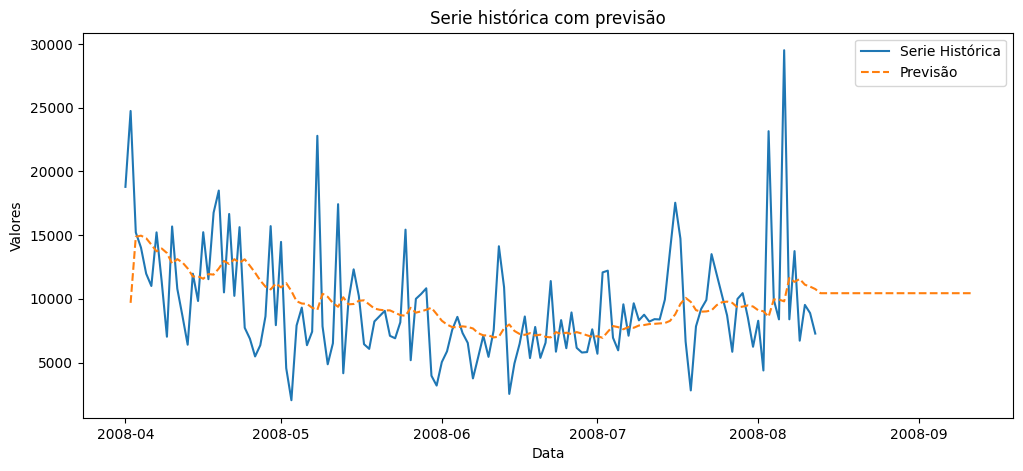

BIC = 2612 - Training RMSE = 4601


In [7]:
forecast = model1.forecast(30)
previsao = model1.fittedvalues[1:]
previsao1 = pd.concat([previsao, forecast])
rmse = np.sqrt(np.mean(model1.resid**2))
bic = model1.bic
plot_forecast(y,previsao1)
print(f'BIC = {round(bic)} - Training RMSE = {round(rmse)}')

Ok, BIC = 2612, RMSE = 4601 não sei se é bom, mas vamos explorar como melhorar o modelo. Talvez com uma Regressão:

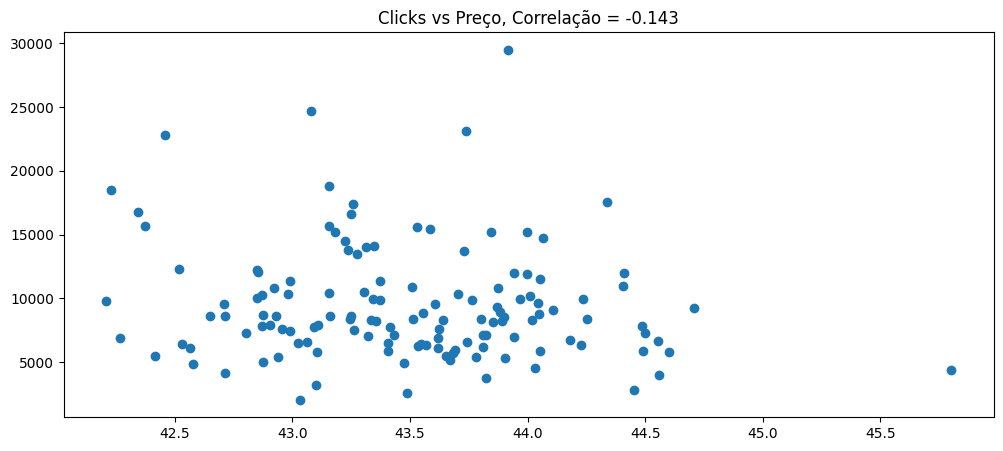

In [8]:
x = df['price']
correl = round(y.corr(x),3)
plt.scatter(x, y)
plt.title(f'Clicks vs Preço, Correlação = {correl}')
plt.show()

In [9]:
import statsmodels.api as sm

model2 = sm.OLS(y, sm.add_constant(x)).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                 clicks   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.759
Date:                Mon, 17 Mar 2025   Prob (F-statistic):             0.0991
Time:                        23:28:07   Log-Likelihood:                -1315.2
No. Observations:                 134   AIC:                             2634.
Df Residuals:                     132   BIC:                             2640.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.549e+04   2.77e+04      2.003      0.0

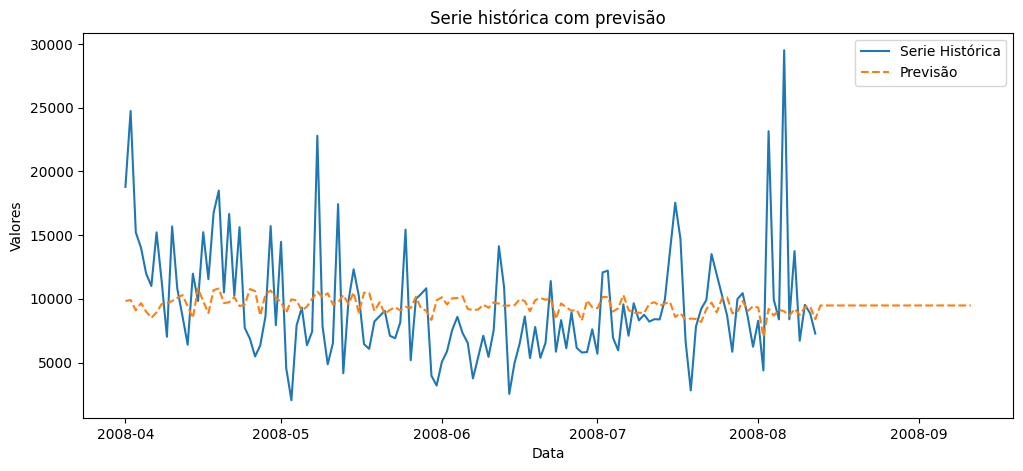

BIC = 2640 - Training ASE = 4429


In [10]:
ultima = df.index[-1]
primeiro_for = ultima + pd.Timedelta(days=1)
for_range = pd.date_range(start=primeiro_for, periods=30)
media_preco = df['price'].mean()
preco_futuro = pd.Series([media_preco]*30, index = for_range)
preco_futuro_df = pd.DataFrame({'const': 1, 'price': preco_futuro})
forecast = model2.predict(preco_futuro_df)
previsao = model2.fittedvalues
previsao2 = pd.concat([previsao, forecast])
rmse = np.sqrt(np.mean(model2.resid**2))
bic = model2.bic
plot_forecast(y, previsao2)
print(f'BIC = {round(bic)} - Training ASE = {round(rmse)}')

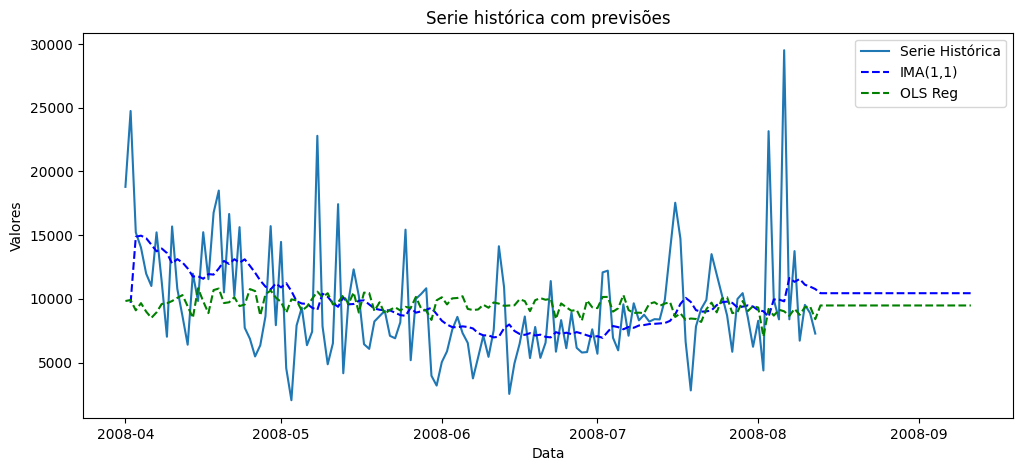

In [11]:
compara_previsoes(y,[previsao1,previsao2], ['IMA(1,1)','OLS Reg'])

Como combinar os dois modelos?

                               SARIMAX Results                                
Dep. Variable:                 clicks   No. Observations:                  134
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1303.587
Date:                Mon, 17 Mar 2025   AIC                           2615.174
Time:                        23:29:20   BIC                           2626.735
Sample:                    04-01-2008   HQIC                          2619.872
                         - 08-12-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
price        -95.7440    118.044     -0.811      0.417    -327.107     135.619
ar.L1          0.2240      0.084      2.659      0.008       0.059       0.389
ma.L1         -1.0000      0.078    -12.787      0.0

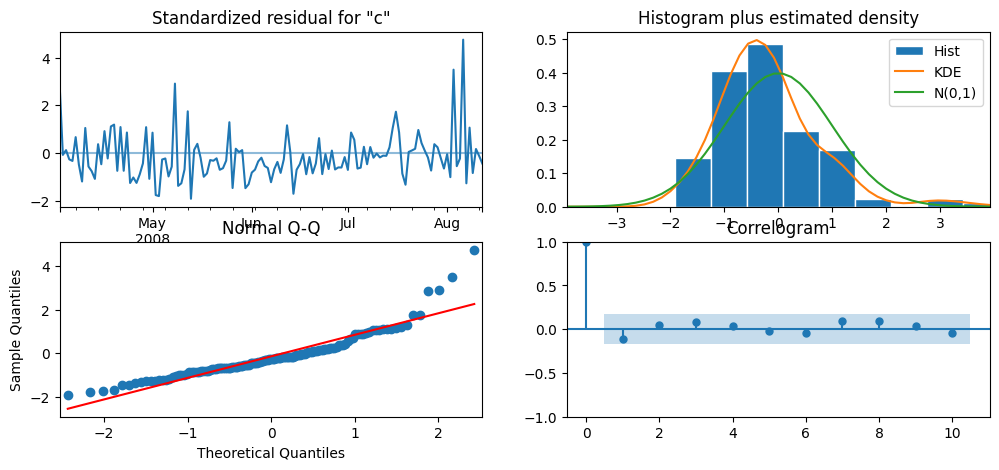

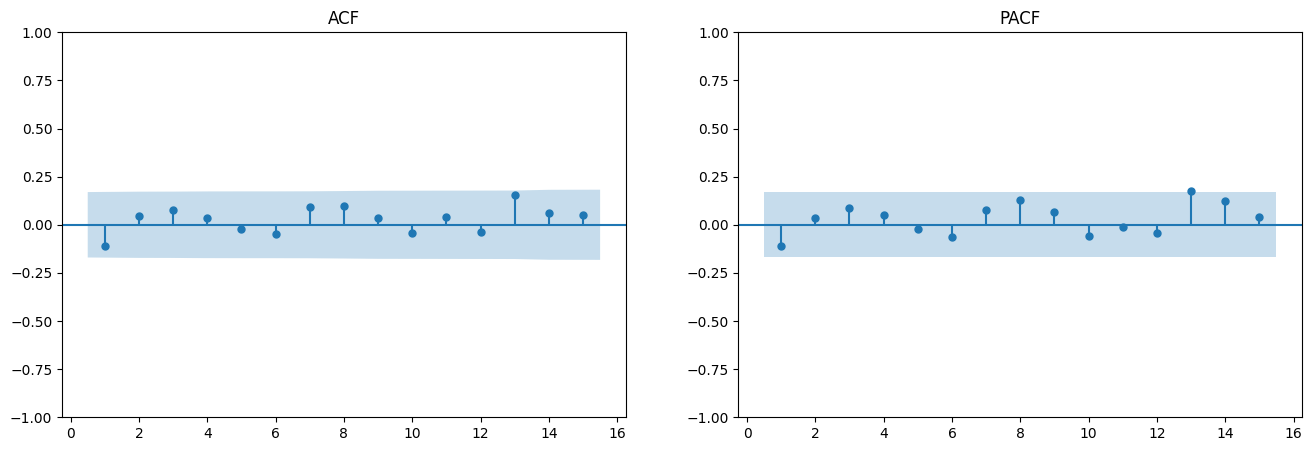

In [14]:
model3 = SARIMAX(y, order=(1,1,1), exog=x).fit(disp=False)
diagnostico(model3)

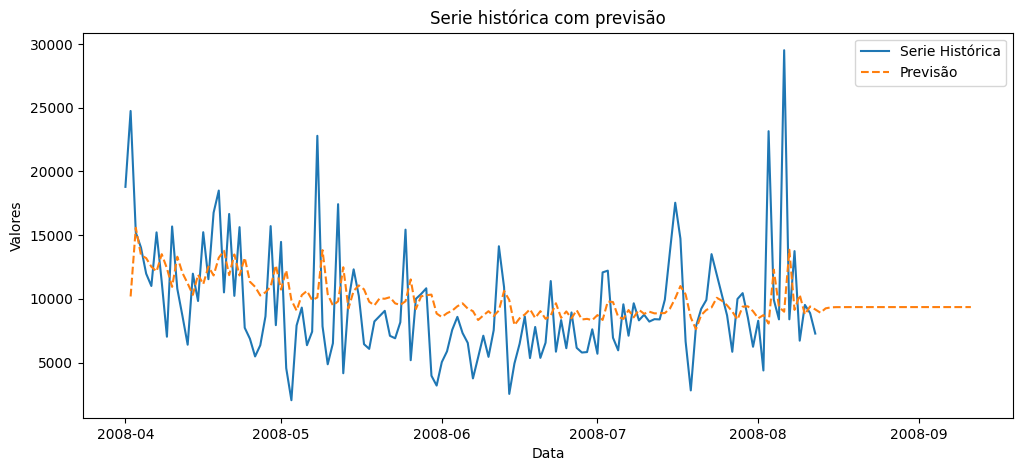

BIC = 2627 - Training RMSE = 4810


In [15]:
forecast = model3.get_forecast(steps=30, exog=preco_futuro).predicted_mean
previsao = model3.fittedvalues[1:]
previsao3 = pd.concat([previsao, forecast])
rmse = np.sqrt(np.mean(model3.resid**2))
bic = model3.bic
plot_forecast(y,previsao3)
print(f'BIC = {round(bic)} - Training RMSE = {round(rmse)}')

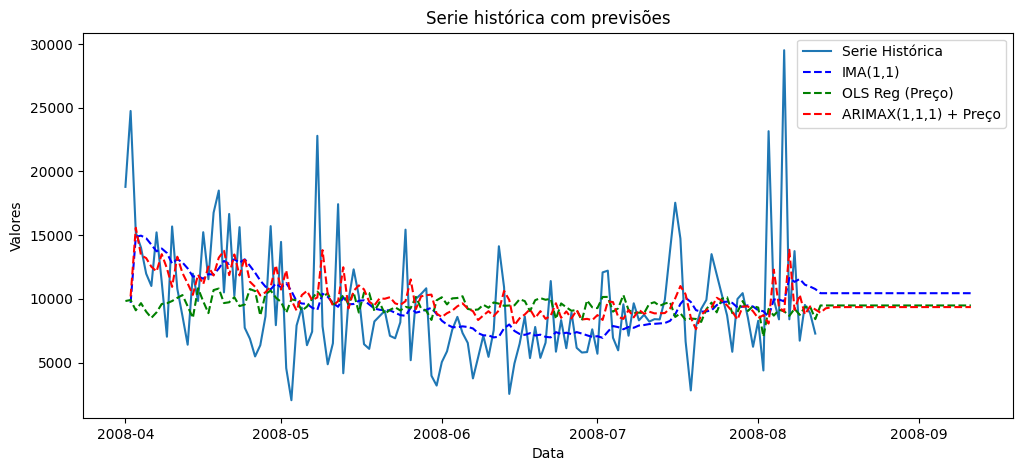

In [18]:
compara_previsoes(y, [previsao1,previsao2,previsao3],  ['IMA(1,1)','OLS Reg (Preço)', 'ARIMAX(1,1,1) + Preço'])

Vamos tentar melhorar esse ARIMAX.

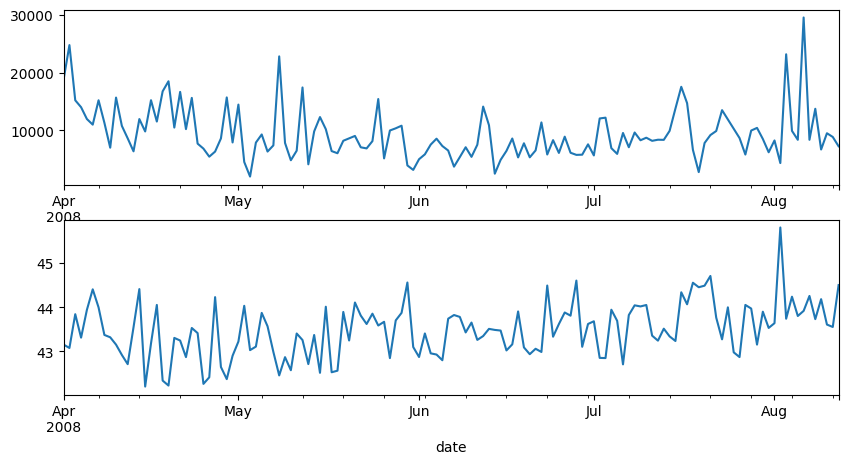

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
y.plot(ax=ax[0])
x.plot(ax=ax[1])
plt.show()

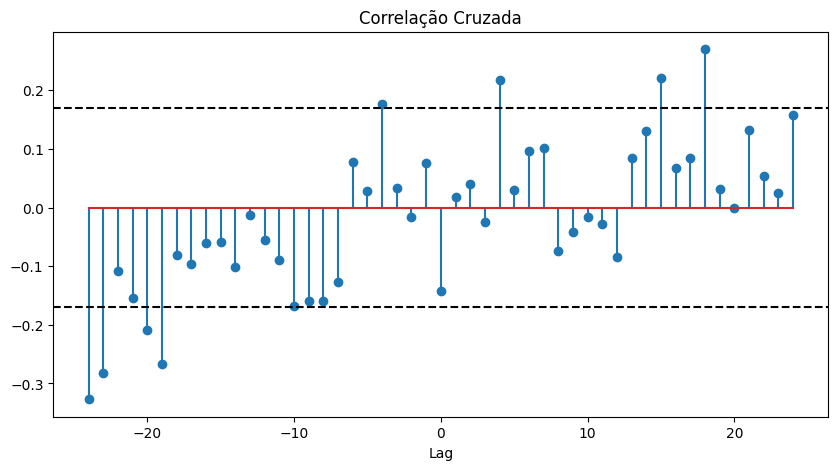

In [19]:
correlacao_cruzada(y,x)

                               SARIMAX Results                                
Dep. Variable:                 clicks   No. Observations:                  130
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1253.147
Date:                Mon, 17 Mar 2025   AIC                           2516.293
Time:                        23:29:53   BIC                           2530.592
Sample:                    04-05-2008   HQIC                          2522.103
                         - 08-12-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
price      -1543.0530    460.195     -3.353      0.001   -2445.019    -641.088
price_4     1811.2194    404.831      4.474      0.000    1017.765    2604.674
ar.L1          0.0635      0.112      0.569      0.5

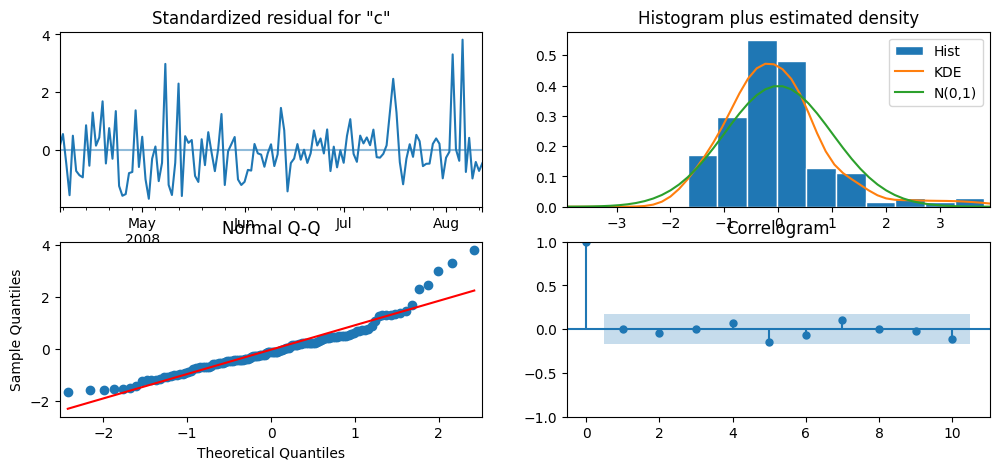

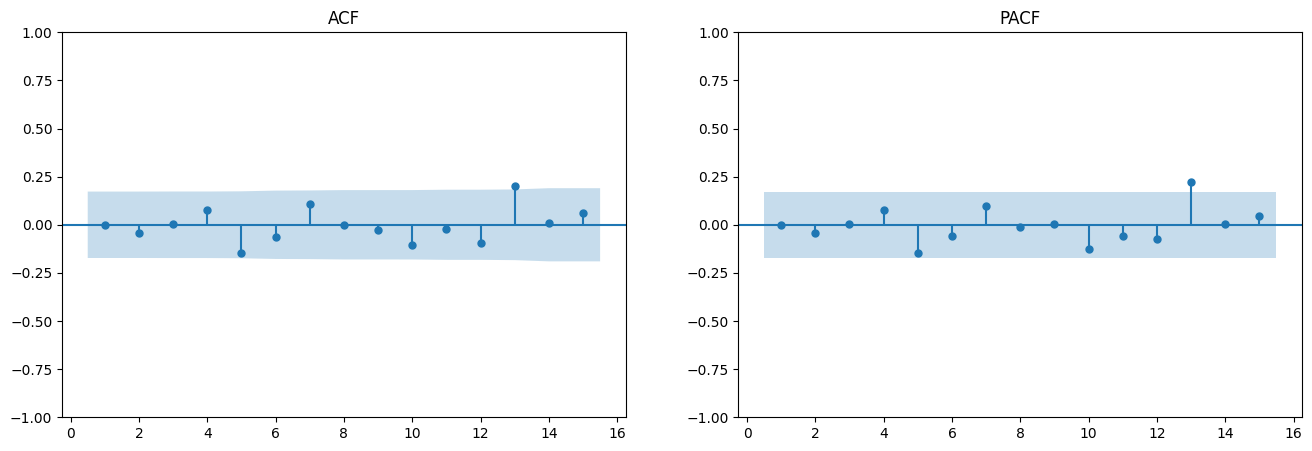

In [20]:
df['price_4'] = df['price'].shift(4)
df = df.dropna()
model4 = SARIMAX(df['clicks'], order = (1,1,1), exog=df[['price','price_4']]).fit(disp=False)
diagnostico(model4)

In [24]:
compara_estatisticas( [model1,model2,model3,model4], ['IMA(1,1)','OLS Reg Preço', 'ARIMAX(1,1,1) + Preço', 'ARIMAX(1,1,1) + Preço + Preço(4)'])

BIC = 2612 -- AIC = 2606 --  RMSE = 4601 - IMA(1,1)
BIC = 2640 -- AIC = 2634 --  RMSE = 4429 - OLS Reg Preço
BIC = 2627 -- AIC = 2615 --  RMSE = 4810 - ARIMAX(1,1,1) + Preço
BIC = 2531 -- AIC = 2516 --  RMSE = 3972 - ARIMAX(1,1,1) + Preço + Preço(4)


In [55]:
ultimos_4_precos = df['price'].iloc[-4:]
ultimos_4_precos.index = ultimos_4_precos.index + pd.Timedelta(days=4)
precos_futuros_lag_4 = pd.concat([ultimos_4_precos,preco_futuro.iloc[4:]])
precos = pd.DataFrame({'price': preco_futuro,'price_4': precos_futuros_lag_4 })
precos.head(6)


,price,price_4
2008-08-13,43.484408,44.182033
2008-08-14,43.484408,43.608260
2008-08-15,43.484408,43.553363
2008-08-16,43.484408,44.500469
2008-08-17,43.484408,43.484408
2008-08-18,43.484408,43.484408


In [56]:
forecast = model4.get_forecast(steps=30, exog=precos).predicted_mean
previsao = model4.fittedvalues[1:]
previsao4 = pd.concat([previsao, forecast])

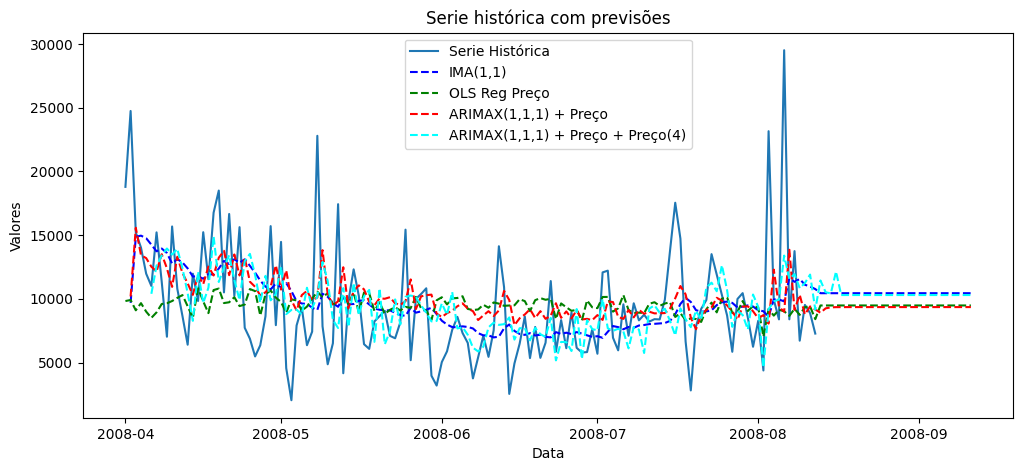

In [57]:
compara_previsoes(y, [previsao1,previsao2,previsao3, previsao4],  ['IMA(1,1)','OLS Reg Preço', 'ARIMAX(1,1,1) + Preço', 'ARIMAX(1,1,1) + Preço + Preço(4)'])

# Análise de Cenários

In [ ]:
preco_f = [45]*24

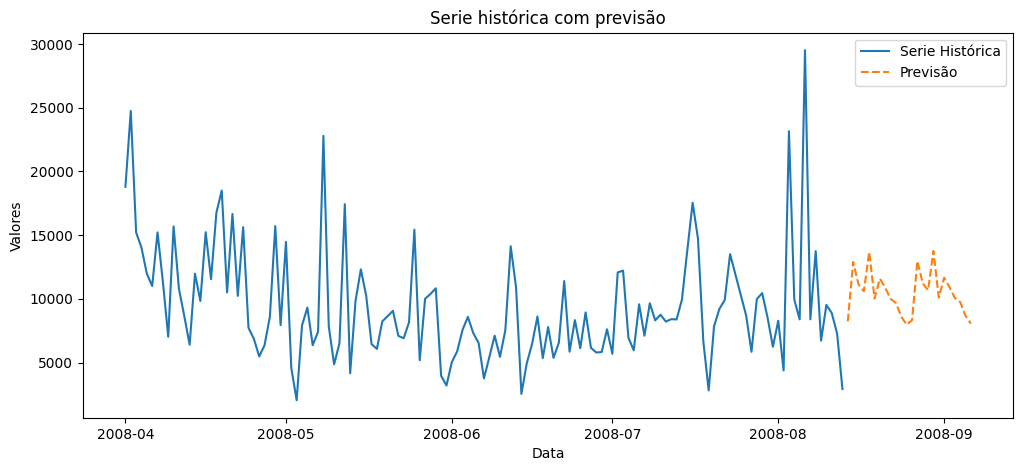

In [ ]:
previsao1 = model1.get_forecast(steps=24, exog=preco_f).predicted_mean
plot_forecast(df['clicks'], previsao1)


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             clicks   No. Observations:                  131
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1160.743
Date:                            Fri, 14 Mar 2025   AIC                           2329.485
Time:                                    20:07:34   BIC                           2340.568
Sample:                                04-05-2008   HQIC                          2333.985
                                     - 08-13-2008                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
price_4      265.4741     75.870      3.499      0.000     116.771     414.177
ma.L1         -0.9082      0.051    -17.884      0.000      -1.008      -0.809
ma.S.L12      -0.8678      0.156     -5.546      0.000      -1.174      -0.561
sigma2      1.888e+07      0.000   9.41e+10      0.000    1.89e+07    1.89e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               125.35
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                             1.40
Prob(H) (two-sided):                  0.39   Kurtosis:                         7.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.54e+26. Standard errors may be unstable.
"""

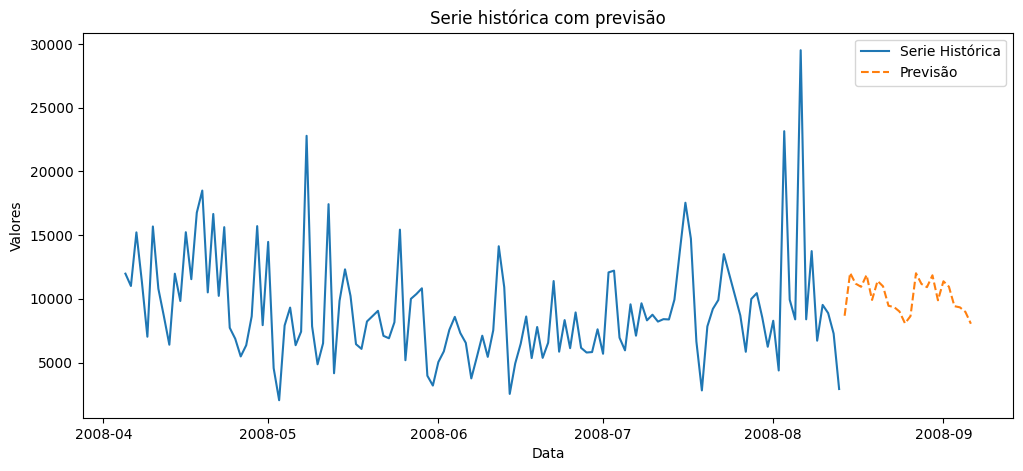

In [ ]:
previsao2 = model2.get_forecast(steps=24, exog=preco_f).predicted_mean
plot_forecast(df['clicks'], previsao2)

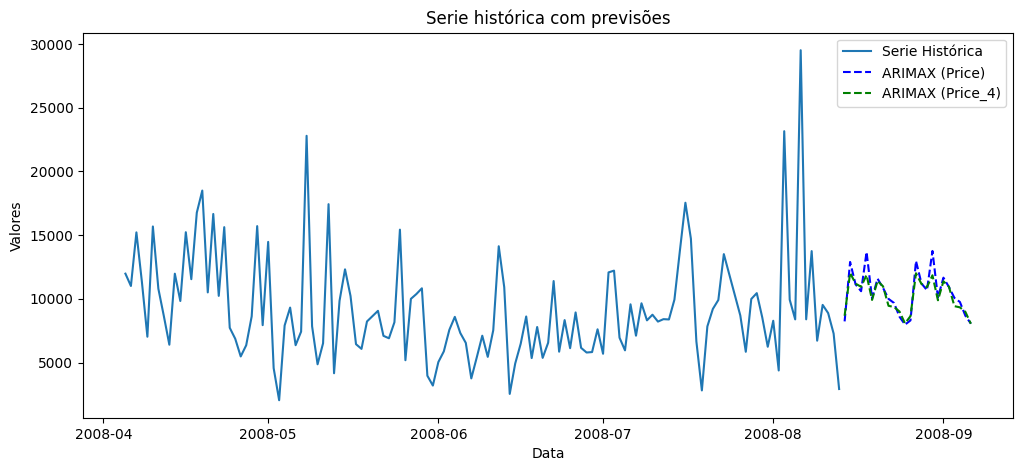

In [ ]:
compara_previsoes(df['clicks'], [previsao1,previsao2], ['ARIMAX (Price)', 'ARIMAX (Price_4)'])

In [ ]:
passos = 24
preco_medio = df['price'].mean()
preco_medio_f = [preco_medio]*passos
preco_min_f = [30]*passos


previsao1 = model1.get_forecast(steps=24, exog=preco_medio_f).predicted_mean
previsao2 = model1.get_forecast(steps=24, exog=preco_min_f).predicted_mean

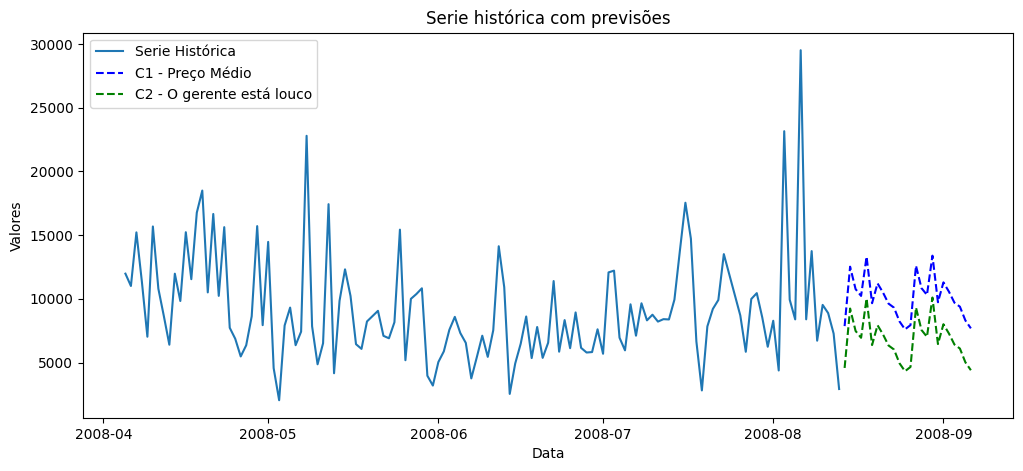

In [ ]:
compara_previsoes(df['clicks'], [previsao1,previsao2], ['C1 - Preço Médio', 'C2 - O gerente está louco'])